In [1]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
import math
import os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [2]:
filepath = "./mozart/"
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [3]:
      
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

Mozart= extract_notes(all_midis)
print("Total notes in all the Mozart midis in the dataset:", len(Mozart))

Total notes in all the Mozart midis in the dataset: 55802


In [4]:
print("First fifty values:", Mozart[:50])

First fifty values: ['2.6.9', '9.2', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5', 'B5', 'C#6', 'D6', 'A5', 'F#3', 'D4', 'F#5', 'D3', 'D4', 'A5', 'E3', 'G5', 'F#5', 'D4', 'G5', 'A5', 'A3', 'G5', 'C#4', 'F5', '2', 'F#5', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5']


In [5]:
count_num = Counter(Mozart)
print("Total unique notes in the Mozart:", len(count_num))

Total unique notes in the Mozart: 229


In [6]:

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note:", Average(Recurrence))
print("Most frequent note:", max(Recurrence), "times")
print("Least frequent note:", min(Recurrence), "time")

Average recurrenc for a note: 243.6768558951965
Most frequent note: 2355 times
Least frequent note: 1 time


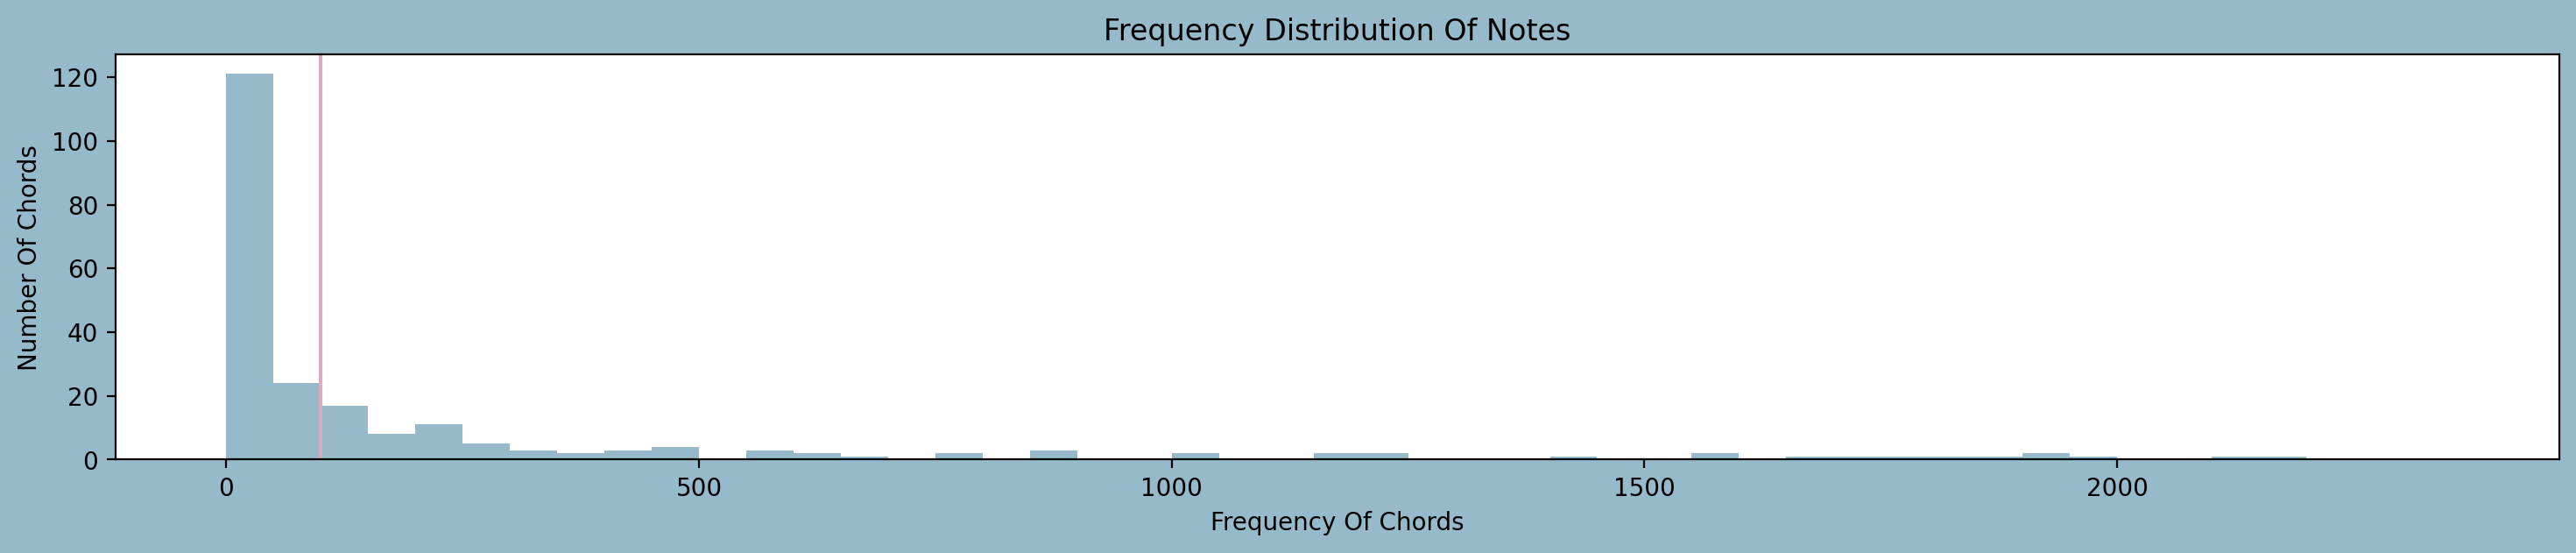

In [7]:

plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes")
plt.xlabel("Frequency Of Chords")
plt.ylabel("Number Of Chords")
plt.show()

In [8]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 145


In [9]:
for element in Mozart:
    if element in rare_note:
        Mozart.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Mozart))

Length of Corpus after elemination the rare notes: 53122


In [10]:
symb = sorted(list(set(Mozart)))

L_mozart = len(Mozart) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_mozart)
print("Number of unique characters:", L_symb)

Total number of characters: 53122
Number of unique characters: 167


In [11]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_mozart - length, 1):
    feature = Mozart[i:i + length]
    target = Mozart[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences:", L_datapoints)

Total number of sequences: 53082


In [12]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [13]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [15]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 40, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 167)               42919     
Total params: 1,948,839
Trainable params: 1,948,839
Non-trainable params: 0
______________________________________________

In [ ]:
#Training the Model
MozartModel = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
166/166 [==============================] - 141s 827ms/step - loss: 4.1389
Epoch 2/200
166/166 [==============================] - 153s 921ms/step - loss: 4.0755
Epoch 3/200
166/166 [==============================] - 158s 954ms/step - loss: 4.0693
Epoch 4/200
166/166 [==============================] - 159s 960ms/step - loss: 4.0670
Epoch 5/200
166/166 [==============================] - 154s 928ms/step - loss: 4.0650
Epoch 6/200
166/166 [==============================] - 146s 878ms/step - loss: 4.0662
Epoch 7/200
166/166 [==============================] - 155s 937ms/step - loss: 4.0643
Epoch 8/200
166/166 [==============================] - 155s 935ms/step - loss: 4.0625
Epoch 9/200
166/166 [==============================] - 148s 892ms/step - loss: 4.0624
Epoch 10/200
166/166 [==============================] - 155s 933ms/step - loss: 4.0310
Epoch 11/200
166/166 [==============================] - 149s 897ms/step - loss: 3.9913
Epoch 12/200
166/166 [==============================